## Imports and settings

In [1]:
import src
import keras.backend as K
from os import *
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8530528710653125936
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6195480886844375462
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [6]:
train, xval, test = src.load_datasets(past_frames=1)

Training data: (7500, 64, 64, 2)
Validation data: (1500, 64, 64, 2)
Test data: (1000, 64, 64, 2)


In [7]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train, xval, test, past_frames=1, augment=False)

Shape of training data:  (7500, 64, 64, 1) 
Shape of training truth:  (7500, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 1) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 1) 
Shape of test truth:  (1000, 64, 64, 1)


## U-net

In [8]:
def unet2(input_shape=(64, 64, 1), dropout=0.0, batchnorm=False):
    lr = 0.1
    
    init = keras.layers.Input(shape=input_shape)
    ConvDown1  = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(2,2),padding="same")(init)
    if batchnorm:
        ConvDown1 = keras.layers.BatchNormalization()(ConvDown1)
    Lr1 = keras.layers.LeakyReLU(alpha=lr)(ConvDown1)
    if (dropout > 0) and (dropout <= 1):
        Lr1 = keras.layers.Dropout(dropout)(Lr1)
    #32
    ConvDown2  = keras.layers.Conv2D(filters=64,kernel_size=(4,4),strides=(2,2),padding="same")(Lr1)
    if batchnorm:
        ConvDown2 = keras.layers.BatchNormalization()(ConvDown2)
    Lr2 = keras.layers.LeakyReLU(alpha=lr)(ConvDown2)
    if (dropout > 0) and (dropout <= 1):
        Lr2 = keras.layers.Dropout(dropout)(Lr2)
    #16
    ConvDown3  = keras.layers.Conv2D(filters=128,kernel_size=(4,4),strides=(2,2),padding="same")(Lr2)
    if batchnorm:
        ConvDown3 = keras.layers.BatchNormalization()(ConvDown3)
    Lr3 = keras.layers.LeakyReLU(alpha=lr)(ConvDown3)
    if (dropout > 0) and (dropout <= 1):
        Lr3 = keras.layers.Dropout(dropout)(Lr3)
    #8
    ConvDown4  = keras.layers.Conv2D(filters=256,kernel_size=(4,4),strides=(2,2),padding="same")(Lr3)
    if batchnorm:
        ConvDown4 = keras.layers.BatchNormalization()(ConvDown4)
    Lr4 = keras.layers.LeakyReLU(alpha=lr)(ConvDown4)
    if (dropout > 0) and (dropout <= 1):
        Lr4 = keras.layers.Dropout(dropout)(Lr4)
    #4
    ConvDown5  = keras.layers.Conv2D(filters=256,kernel_size=(4,4),strides=(2,2),padding="same")(Lr4)
    if batchnorm:
        ConvDown5 = keras.layers.BatchNormalization()(ConvDown5)
    Lr5 = keras.layers.LeakyReLU(alpha=lr)(ConvDown5)
    if (dropout > 0) and (dropout <= 1):
        Lr5 = keras.layers.Dropout(dropout)(Lr5)
    #2
    
    UpConv1 = keras.layers.Conv2DTranspose(filters=256,kernel_size=(4,4),strides=(2,2),padding="same")(Lr5)
    if batchnorm:
        UpConv1 = keras.layers.BatchNormalization()(UpConv1)
    Lr6 = keras.layers.LeakyReLU(alpha=lr)(UpConv1)
    if (dropout > 0) and (dropout <= 1):
        Lr6 = keras.layers.Dropout(dropout)(Lr6)
    merge1  = keras.layers.concatenate([ConvDown4,Lr6],axis=-1)
    #4
    UpConv2 = keras.layers.Conv2DTranspose(filters=128,kernel_size=(4,4),strides=(2,2),padding="same")(merge1)
    if batchnorm:
        UpConv2 = keras.layers.BatchNormalization()(UpConv2)
    Lr7  = keras.layers.LeakyReLU(alpha=lr)(UpConv2)
    if (dropout > 0) and (dropout <= 1):
        Lr7 = keras.layers.Dropout(dropout)(Lr7)
    merge2  = keras.layers.concatenate([ConvDown3,Lr7],axis=-1)
    #8
    UpConv3 = keras.layers.Conv2DTranspose(filters=64,kernel_size=(4,4),strides=(2,2),padding="same")(merge2)
    if batchnorm:
        UpConv3 = keras.layers.BatchNormalization()(UpConv3)
    Lr8  = keras.layers.LeakyReLU(alpha=lr)(UpConv3)
    if (dropout > 0) and (dropout <= 1):
        Lr8 = keras.layers.Dropout(dropout)(Lr8)
    merge3  = keras.layers.concatenate([ConvDown2,Lr8],axis=-1)
    #16
    UpConv4 = keras.layers.Conv2DTranspose(filters=32,kernel_size=(4,4),strides=(2,2),padding="same")(merge3)
    if batchnorm:
        UpConv4 = keras.layers.BatchNormalization()(UpConv4)
    Lr9  = keras.layers.LeakyReLU(alpha=lr)(UpConv4)
    if (dropout > 0) and (dropout <= 1):
        Lr9 = keras.layers.Dropout(dropout)(Lr9)
    merge4  = keras.layers.concatenate([ConvDown1,Lr9],axis=-1)
    #32
    UpConv5 = keras.layers.Conv2DTranspose(filters=1,kernel_size=(4,4),strides=(2,2),padding="same")(merge4)
    if batchnorm:
        UpConv5 = keras.layers.BatchNormalization()(UpConv5)
    Lr10  = keras.layers.LeakyReLU(alpha=lr)(UpConv5)
    if (dropout > 0) and (dropout <= 1):
        Lr10 = keras.layers.Dropout(dropout)(Lr10)
    #64
    
    return keras.models.Model(inputs=init, outputs=Lr10)
unet2().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   544         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 32, 32, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 64)   32832       leaky_re_lu_11[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [35]:
model = src.unet(dropout=0, batchnorm=True)

In [36]:
#train the model
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss=src.custom_loss("l2"), metrics=[src.relative_error_tensor]) 

***Using L2 loss.***
Tensor("metrics_3/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("conv2d_45_target:0", shape=(?, ?, ?, ?), dtype=float32)


In [37]:
model.fit(gan_train,
          gan_truth,
          batch_size = 64,
          epochs=7,
          validation_data=(gan_val,gan_val_truth),
          shuffle = False)

Train on 7500 samples, validate on 1500 samples
Epoch 1/7
7500/7500 [==============================] - 88s 12ms/step - loss: 0.0792 - relative_error_tensor: 0.8887 - val_loss: 0.0588 - val_relative_error_tensor: 0.8723
Epoch 2/7
6912/7500 [==========================>...] - ETA: 6s - loss: 0.0364 - relative_error_tensor: 0.5812

KeyboardInterrupt: 

In [ ]:
hist = model.history
hist.history.keys()
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig('training_bn_d0.png')

In [31]:
#test
predictions = model.predict(gan_test, batch_size=100)
truth       = gan_test_truth
truth.shape

(1000, 64, 64, 1)

In [32]:
args = src.arg_getter(truth, predictions)
args[-1]

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:752: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)


413

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:752: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)


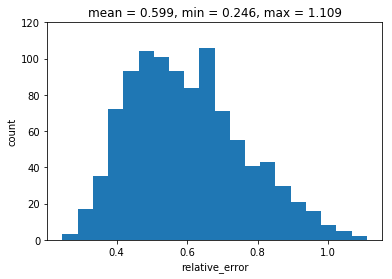

In [33]:
error_images, error_vals, error_means = src.error_distribution(truth,predictions,metric="relative_error")

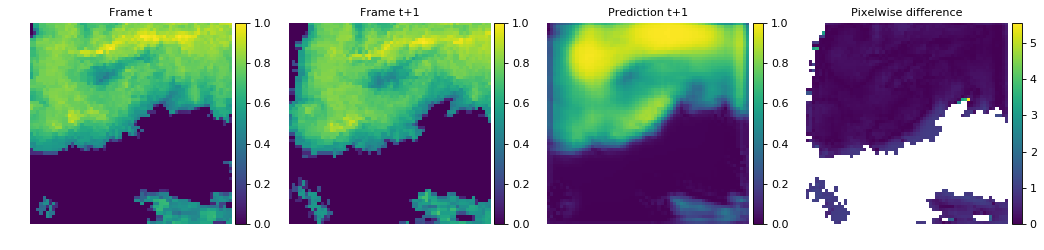

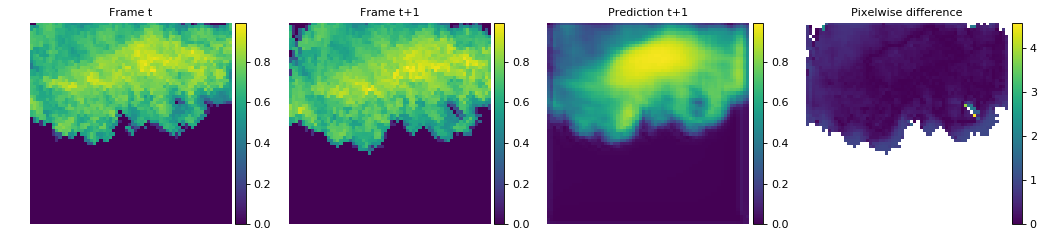

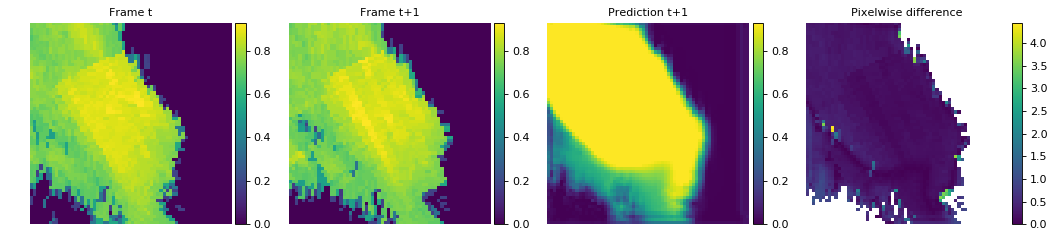

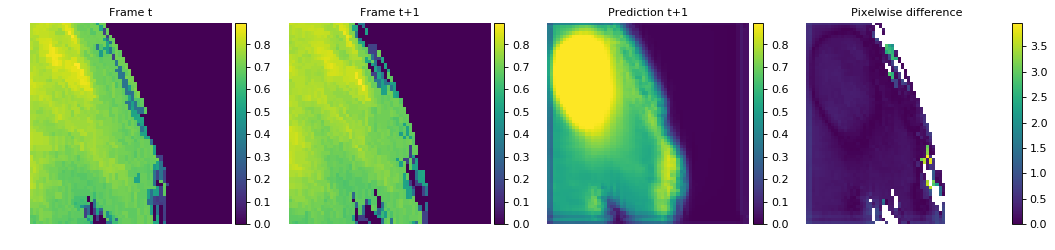

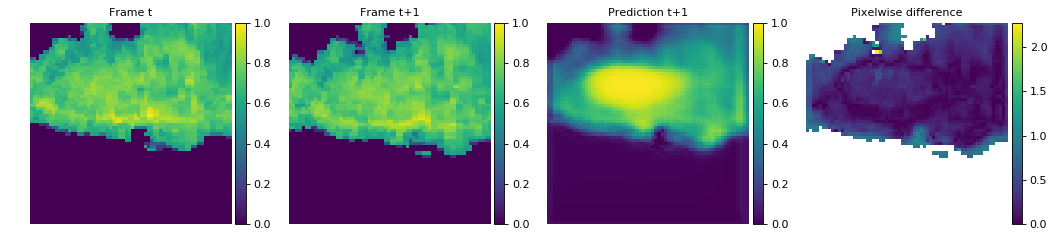

In [34]:
src.result_plotter(args[:5], (gan_test[:,:,:,0], truth[:,:,:,0], predictions[:,:,:,0], error_images[:,:,:,0]))

In [ ]:
scores = src.calculate_skill_scores(predictions, truth, x=gan_test, threshold=0.2)

In [ ]:
scores